In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

from resnet import ResNet
from unet import UNet
from dnn import DNN
from utils import *

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True
0
1
Tesla V100-PCIE-16GB


In [3]:
cls_num_list_train = [0,0,0]
cls_num_list_test = [0,0,0]
n = 0
bigmat = []

for folder in ["train","test"]:
    for cls_idx,subfolder in enumerate(["AD","CN","MCI"]):
        files = os.listdir('EHR/' + folder + '/' + subfolder)
        
        for file in files:
            mat = np.load('EHR/' + folder + '/' + subfolder + '/' + file)
            
            if folder=="train":
                bigmat.append(mat)
                n += 1
                cls_num_list_train[cls_idx] += 1
            if folder=="test":
                cls_num_list_test[cls_idx] +=1
            
            print(folder, subfolder, file, mat.shape)
            # if(mat.shape[0] != 166):
            #     os.remove(folder + '/' + subfolder + '/' + file)
            
            # np.save(folder + '/' + subfolder + '/' + file, mat)

train AD 094_S_1402.npy (100,)
train AD 005_S_0929.npy (100,)
train AD 021_S_0642.npy (100,)
train AD 094_S_1164.npy (100,)
train AD 029_S_0836.npy (100,)
train AD 027_S_0850.npy (100,)
train AD 021_S_0343.npy (100,)
train AD 029_S_1056.npy (100,)
train AD 126_S_1221.npy (100,)
train AD 037_S_0627.npy (100,)
train AD 007_S_1339.npy (100,)
train AD 031_S_0554.npy (100,)
train AD 021_S_1109.npy (100,)
train AD 127_S_0431.npy (100,)
train AD 033_S_0889.npy (100,)
train AD 053_S_1044.npy (100,)
train AD 127_S_0754.npy (100,)
train AD 006_S_0653.npy (100,)
train AD 127_S_1382.npy (100,)
train AD 098_S_0149.npy (100,)
train AD 031_S_0321.npy (100,)
train AD 005_S_0221.npy (100,)
train AD 005_S_1341.npy (100,)
train AD 033_S_1281.npy (100,)
train AD 094_S_1397.npy (100,)
train AD 007_S_0316.npy (100,)
train AD 024_S_1171.npy (100,)
train AD 027_S_1254.npy (100,)
train AD 094_S_1090.npy (100,)
train AD 126_S_0891.npy (100,)
train AD 116_S_0370.npy (100,)
train AD 033_S_1285.npy (100,)
train AD

In [4]:
print(cls_num_list_train, cls_num_list_test)

[34, 52, 89] [8, 21, 35]


In [5]:
bigmat = np.stack(bigmat)
bigmat.shape

(175, 100)

In [6]:
# !ls train/CN -a

In [7]:
# !rm -R EHR/train/AD/.ipynb_checkpoints
# !rm -R EHR/test/AD/.ipynb_checkpoints
# !rm -R EHR/train/CN/.ipynb_checkpoints
# !rm -R EHR/test/CN/.ipynb_checkpoints
# !rm -R EHR/train/MCI/.ipynb_checkpoints
# !rm -R EHR/test/MCI/.ipynb_checkpoints
# !rm -R EHR/train/.ipynb_checkpoints
# !rm -R EHR/test/.ipynb_checkpoints
# !ls train -a
# !ls test -a

In [25]:
data = bigmat
mean_list = np.mean(data,axis=0)
std_list = np.std(data,axis=0) + 0.01

In [26]:
# transform_train = transforms.Compose([transforms.ToTensor(),
#                                      transforms.Normalize(mean_list, std_list)
#                                     ])
# transform_test = transforms.Compose([transforms.ToTensor(),
#                                     transforms.Normalize(mean_list, std_list)])

def npy_loader_train(path):
    mat = np.load(path)
    # mat = transform_train(mat)
    mat = (mat - mean_list)/std_list
    mat = torch.Tensor(mat)
    return mat

def npy_loader_test(path):
    mat = np.load(path)
    # mat = transform_test(mat)
    mat = (mat - mean_list)/std_list
    mat = torch.Tensor(mat)
    return mat

trainset = datasets.DatasetFolder(root="EHR/train", loader=npy_loader_train, extensions=(".npy"))
testset = datasets.DatasetFolder(root="EHR/test", loader=npy_loader_test, extensions=(".npy"))

trainloader = DataLoader(trainset, batch_size=2, shuffle=True)
testloader = DataLoader(testset, batch_size=2, shuffle=False)

In [27]:
# for x,y in trainloader:
#     print(x)
#     break

## Model

In [54]:
model = DNN(in_channels= 100, num_classes=3)

print(sum(p.numel() for p in model.parameters()), "parameters")
x = torch.randn(1,100)
model(x)

1043 parameters


tensor([[0.4773, 0.5295, 0.5943]], grad_fn=<SigmoidBackward0>)

## Training

In [55]:
per_cls_weights = [0.5,0.35,0.15]
criterion = nn.CrossEntropyLoss(weight=torch.tensor(per_cls_weights)) # CE Loss, Takes care of applying softmax

# per_cls_weights = reweight(cls_num_list_train, beta=0.999)
# criterion = FocalLoss(weight=per_cls_weights, gamma=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adam optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) # SGD

device = 'cpu'
model = model.to(device)
criterion = criterion.to(device)

In [56]:
train_loss_list = []
test_loss_list = []

for epoch in range(20):  # num epochs
    
    # Training
    model.train() # Set to train mode
    running_loss = 0.0
    running_corrects = 0

    for i, data in enumerate(trainloader): # Get data batch-wise
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.shape, inputs.dtype)
        # labels = labels.type(torch.LongTensor)

        # zero out gradients
        optimizer.zero_grad()

        outputs = model(inputs) # forward pass
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels) # Get loss
        loss.backward() # Backward pass
        optimizer.step() # Optimize model weights

        _, preds = torch.max(outputs, 1) # Get predictions
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Get loss and accuracy
    train_loss = (running_loss / len(trainset))
    train_loss_list.append(train_loss.item())
    train_accuracy = (running_corrects.float() / len(trainset))

    # Testing
    model.eval() # Set to eval mode
    running_loss = 0.0
    running_corrects = 0
    y = []; yhat = []

    for i, data in enumerate(testloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # labels = labels.type(torch.LongTensor)

        # forward + backward + optimize
        with torch.no_grad(): # Don't build computation graph for testing
            outputs = model(inputs)
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        y.append(labels.tolist())
        yhat.append(preds.tolist())
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    # Get loss and accuracy
    test_loss = (running_loss / len(testset))
    test_loss_list.append(test_loss.item())
    test_accuracy = (running_corrects.float() / len(testset))

    # Display loss, accuracy values after each epoch
    print("Epoch:{} | Train loss: {:.4f} | Test loss: {:.4f} | Train acc.: {:.4f} | Test acc.: {:.4f}\n"
              .format(epoch, train_loss.item(),test_loss.item(),train_accuracy.item(),test_accuracy.item()))


Epoch:0 | Train loss: 1.0417 | Test loss: 0.9679 | Train acc.: 0.4571 | Test acc.: 0.6406

Epoch:1 | Train loss: 0.9344 | Test loss: 0.9399 | Train acc.: 0.6057 | Test acc.: 0.6406

Epoch:2 | Train loss: 0.9133 | Test loss: 0.9331 | Train acc.: 0.5829 | Test acc.: 0.6406

Epoch:3 | Train loss: 0.8988 | Test loss: 0.9286 | Train acc.: 0.5771 | Test acc.: 0.6250

Epoch:4 | Train loss: 0.8882 | Test loss: 0.9325 | Train acc.: 0.6400 | Test acc.: 0.5469

Epoch:5 | Train loss: 0.8767 | Test loss: 0.9298 | Train acc.: 0.5771 | Test acc.: 0.5469

Epoch:6 | Train loss: 0.8796 | Test loss: 0.9241 | Train acc.: 0.5829 | Test acc.: 0.6250

Epoch:7 | Train loss: 0.8831 | Test loss: 0.9219 | Train acc.: 0.6171 | Test acc.: 0.6406

Epoch:8 | Train loss: 0.8688 | Test loss: 0.9180 | Train acc.: 0.6114 | Test acc.: 0.6562

Epoch:9 | Train loss: 0.8741 | Test loss: 0.9193 | Train acc.: 0.6571 | Test acc.: 0.6562

Epoch:10 | Train loss: 0.8692 | Test loss: 0.9205 | Train acc.: 0.6286 | Test acc.: 0.6562

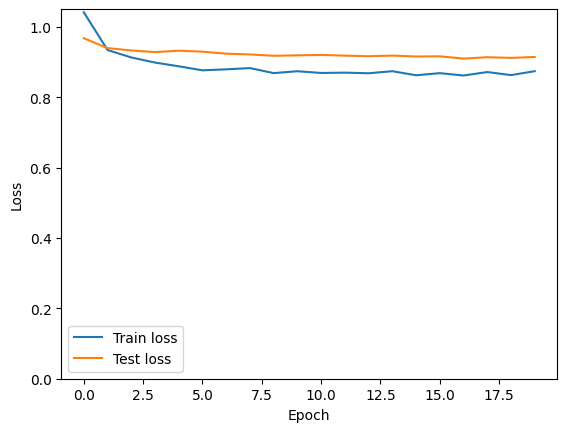

In [58]:
# Loss curves
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.ylim(bottom = 0)
plt.legend(["Train loss", "Test loss"])
plt.show()

## Evaluation

In [59]:
y = np.hstack(y)
yhat = np.hstack(yhat)
print(classification_report(y, yhat, target_names=trainset.classes, digits=4))

              precision    recall  f1-score   support

          AD     0.4211    1.0000    0.5926         8
          CN     0.6667    0.5714    0.6154        21
         MCI     0.8148    0.6286    0.7097        35

    accuracy                         0.6562        64
   macro avg     0.6342    0.7333    0.6392        64
weighted avg     0.7170    0.6562    0.6641        64



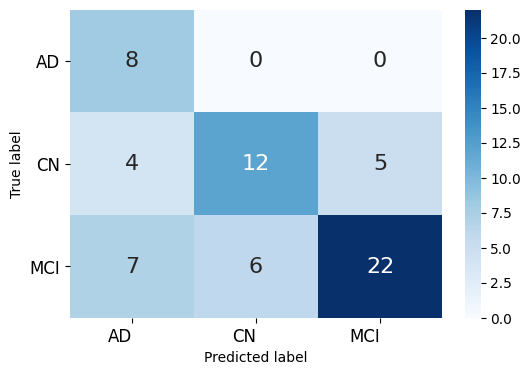

In [60]:
cm=confusion_matrix(y,yhat)
class_names=trainset.classes
#     print(cm)

# Enhanced confusion matrix
plt.figure(figsize=(6,4))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
heatmap = sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={'size':16})

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [61]:
# Save model
# torch.save(model.state_dict(), "checkpoint/" + "DNN.pth")

In [ ]:
# Load
# model.load_state_dict(torch.load("checkpoint/" + "DNN.pth"))
# model.eval()